<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: extragalactic science

## Goal

The goal of this notebook is to show how Fink can contribute to extragalactic science. This notebook includes queries for **Active Galactic Nucleii** and **Supernova** science. 

Real-time analysis for follow-up coordination will be better done through the Fink livestreams which processes and makes available the alert data within minutes of reception. Access through this notebook uses the API access which is not real-time based. We aggregate the data into our API and Science Portal database at the end of each observing night. API access can be useful to analyze last night and older alerts. 

## What is behind?

This notebook will use:
- **Fink cross-match** with close by sources in the  [SIMBAD (Wenger et al. 2020)](https://aas.aanda.org/articles/aas/abs/2000/07/ds1821/ds1821.html) catalogue (within 1'') using [xmatch service](http://cdsxmatch.u-strasbg.fr) provided by the Centre de Données astronomiques de Strasbourg (CDS) .
- **Fink's machine learning classification** scores 
    - [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173) to classify SNe at all light-curve epochs
    - Random Forest (Leoni et al. in prep) and [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract) to classify early (pre-max) SN candidates
- **Fink's extra features** such as color `g-r` or `rate` when possible.

## Environment set up

To run this notebook, you need to import the following libraries (already installed in colab):

In [1]:
import requests
import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

APIURL = 'https://api.fink-portal.org'

# 1st case study: known AGNs

### <font color='blue'>API query:</font> <font color='orange'> latest alerts</font> associated with known AGNs

Each night, alerts are cross-matched in real-time against the CDS SIMBAD database. About 30% of the stream (after applying quality cuts) ends-up with a counter-part. Classified alerts can be then queried using the Fink API service. To know all available classes in SIMBAD, see https://api.fink-portal.org/api/v1/classes. We will first focus on alerts spatially coincident with an AGN featured in the CDS Simbad catalogue:

In [2]:
# Get latests 5 alerts linked to AGNs in a time window
r = requests.post(
  '{}/api/v1/latests'.format(APIURL),
  json={
    'class': '(SIMBAD) AGN',    # tag from CDSxmatch service
    'n': '5' ,                  # number of alerts
    'startdate': '2021-03-01',  # use a start date
    'stopdate': '2021-03-05',   # use a stop date
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

Note that you can also use the `startdate` and `stopdate` arguments in the query. See https://api.fink-portal.org/api/v1/latests to check all the available arguments. This table contains all alerts linked to a CDS catalogue AGN. This includes
- Alert information from ZTF processing (just latest photometry points).
- Fink's added values.

The table schema is described at https://api.fink-portal.org/api/v1/schema.

In [3]:
pdf

,d:cdsxmatch,d:mulens,d:rf_kn_vs_nonkn,d:rf_snia_vs_nonia,d:roid,d:snn_sn_vs_all,d:snn_snia_vs_nonia,i:candid,i:chipsf,i:classtar,...,i:tooflag,i:xpos,i:ypos,d:tracklet,d:tns,v:classification,v:lastdate,v:firstdate,v:lapse,v:constellation
0,AGN,0,0,0,0,0,0,1522554983115015003,2.126123,0.992,...,0,1112.7437,1651.1133,,,AGN,2021-03-03 13:19:10.998,2018-09-06 06:36:04.000,909.279942,Delphinus
1,AGN,0,0,0,0,0,0,1522552633115015000,1.774720,0.663,...,0,1112.0876,1650.0837,,,AGN,2021-03-03 13:15:48.001,2018-09-06 06:36:04.000,909.277593,Delphinus
2,AGN,0,0,0,0,0,0,1522550283115015003,2.139355,0.660,...,0,1111.1361,1649.2211,,,AGN,2021-03-03 13:12:25.004,2018-09-06 06:36:04.000,909.275243,Delphinus
3,AGN,0,0,0,0,0,0,1522547923115015002,2.369038,0.948,...,0,1110.7671,1648.0677,,,AGN,2021-03-03 13:09:00.996,2018-09-06 06:36:04.000,909.272882,Delphinus
4,AGN,0,0,0,0,0,0,1522544521815015007,1.376921,0.669,...,0,1824.8479,1103.0751,,,AGN,2021-03-03 13:04:07.003,2018-08-02 05:36:57.997,944.310521,Aquila


Get objects Ids associated to these alerts (AGNs in ZTF).

In [4]:
recent_AGN_objectIds = pdf['i:objectId'].unique()

### <font color='blue'>API query:</font> get <font color='orange'> photometry </font> for one of these AGNs

You can then use the `objects` API service to get all the photometry about a particular object.

In [5]:
r = requests.post(
  '{}/api/v1/objects'.format(APIURL),
  json={
    'objectId': recent_AGN_objectIds[0],
    'output-format': 'json',
    'withupperlim': 'True',
    'startdate': '2021-03-01', # use a start date
    'stopdate': '2021-03-05', # use a stop date
  }
)

# Format output in a DataFrame
single_object = pd.read_json(io.BytesIO(r.content))

This query can include upper limits and bad  quality  data associated to this object using the argument `withupperlim`.

See the `/api/v1/objects` endpoint on https://api.fink-portal.org to get the list of available arguments.

### <font color='blue'>Plot:</font> light-curve for visualization

See the example on https://fink-broker.readthedocs.io/en/latest/services/search/objectid to plot full lightcurve with layout template.  We implement here an useful function for plotting light-curves in this notebook.

In [6]:
def plot_lc(pdf):
    """ Plot photometry contains in an alert
    
    Parameters
    ----------
    pdf: pandas DataFrame
        Pandas DataFrame with single alert row
    """
    fig = plt.figure(figsize=(15, 6))

    # Colors to plot
    colordic = {1: 'C0', 2: 'C1'}

    # Labels of ZTF filters
    filtdic = {1: 'g', 2: 'r'}

    for filt in [1, 2]:
        # select data from one filter at a time
        maskFilt = pdf['i:fid'] == filt

        # The column `d:tag` is used to check data type
        maskValid = pdf['d:tag'] == 'valid'
        plt.errorbar(
            pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskValid & maskFilt]['i:magpsf'],
            pdf[maskValid & maskFilt]['i:sigmapsf'],
            ls = '', marker='o', color=colordic[filt], label=filtdic[filt]
        )

        maskUpper = pdf['d:tag'] == 'upperlim'
        plt.plot(
            pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskUpper & maskFilt]['i:diffmaglim'],
            ls='', marker='v', color=colordic[filt], markerfacecolor='none'
        )

        maskBadquality = pdf['d:tag'] == 'badquality'
        plt.errorbar(
            pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskBadquality & maskFilt]['i:magpsf'],
            pdf[maskBadquality & maskFilt]['i:sigmapsf'],
            ls='', marker='^', color=colordic[filt]
        )

    plt.gca().invert_yaxis()
    plt.legend()
    plt.title(pdf['i:objectId'][0])
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')
    plt.show()
    msg = """
    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    """
    print(msg)

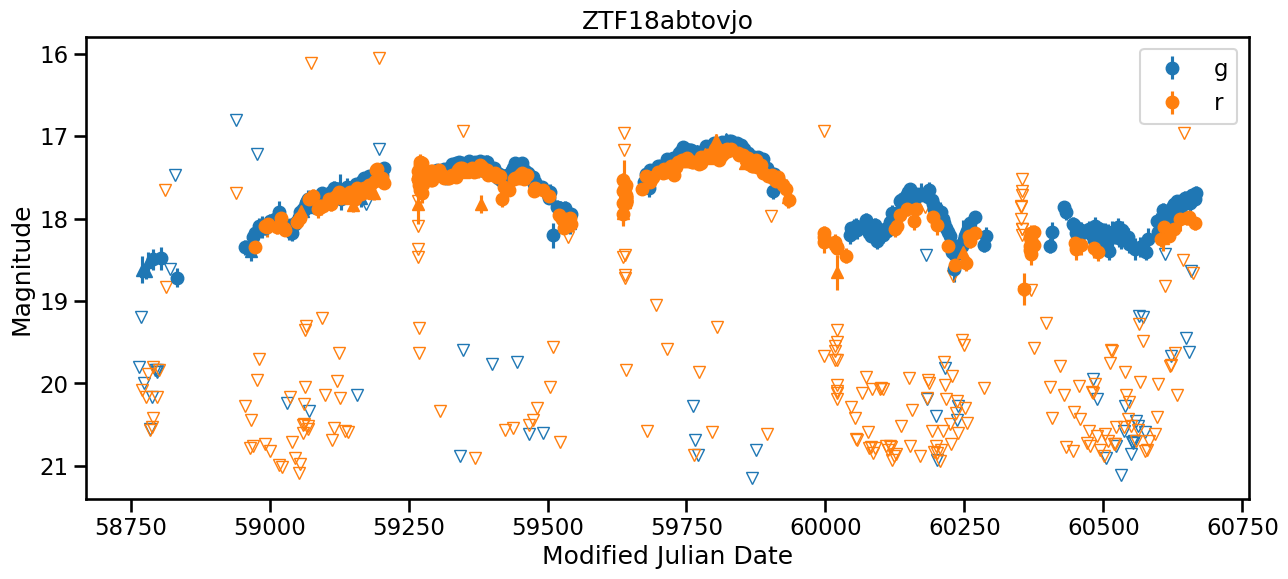


    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    


In [7]:
plot_lc(single_object)

# 2nd case study: early supernovae candidates
**Early supernova candidates is a tag defined and provided by Fink.** 
It requires that the alert has no known transient association (from catalogues), it is relatively new (number of previous detections < 20) and when both a [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173) trained to identify SNe Ia or SNe and a Random Forest (Leoni et al. in prep.) based on [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract) trained to select early supernovae have a probability higher than 50% of this object being a SN.

### <font color='blue'>API query:</font>   <font color='orange'>latest alerts </font>  tagged as early supernovae candidates

In [8]:
# Get latests Early SN candidates (200 max)
r = requests.post(
  '{}/api/v1/latests'.format(APIURL),
  json={
    'class': 'Early SN Ia candidate',
    'n': '200',
    'color': 'True',
    'startdate': '2021-04-01', # use a start date
    'stopdate': '2021-04-13', # use a stop date
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

### <font color='blue'>Inspect:</font> <font Color='orange'>color</font>  of these alerts (if there are g and r measurements in the same night)
Color `v:g-r` is an added value provided by Fink. It is computed as the subtraction of the `magpsf` in the `g` filter minus its corresponding `magpsf` in the `r` filter for an object in a given night. If no same-night different filter measurements are available, the value of color is `NaN`.

In [9]:
# select only valid color measurements
candSNe_w_color = pdf[~pdf["v:g-r"].isna()]

# display 5 of these alerts with inverted column order
candSNe_w_color[candSNe_w_color.columns[::-1]][:5]

,v:constellation,v:lapse,v:firstdate,v:lastdate,v:sigma(rate(g-r)),v:rate(g-r),v:sigma(g-r),v:g-r,v:sigma(rate),v:rate,...,i:classtar,i:chipsf,i:candid,d:snn_snia_vs_nonia,d:snn_sn_vs_all,d:roid,d:rf_snia_vs_nonia,d:rf_kn_vs_nonkn,d:mulens,d:cdsxmatch
0,Ophiucus,9.019630,2021-04-03 11:06:14.999,2021-04-12 11:34:30.996,NaN,NaN,0.094092,-0.022103,NaN,NaN,...,0.983,6.674384,1562482304415015011,0.787034,0.677686,0,0.973,0,0,Unknown
1,Draco,10.044410,2021-04-02 08:38:52.996,2021-04-12 09:42:50.003,NaN,NaN,0.104643,-0.106969,NaN,NaN,...,0.986,3.563279,1562404740215015010,0.818026,0.835022,0,0.698,0,0,Unknown
3,Draco,10.033437,2021-04-02 08:38:52.996,2021-04-12 09:27:01.996,NaN,NaN,0.104643,-0.106969,NaN,NaN,...,0.981,1.512014,1562393770215015003,0.692514,0.751971,0,0.622,0,0,Unknown
4,Ophiucus,8.918762,2021-04-03 11:06:14.999,2021-04-12 09:09:16.001,NaN,NaN,0.094092,-0.022103,0.053127,-0.084717,...,1.000,17.216743,1562381434415015007,0.706066,0.874443,0,0.922,0,0,Unknown
7,Auriga,13.061331,2021-03-30 03:52:44.003,2021-04-12 05:21:03.001,0.076465,-0.004334,0.110112,0.083787,0.060909,-0.023112,...,0.983,4.450665,1562222953415015014,0.872538,0.984186,0,0.941,0,0,Unknown


The table schema is described at https://api.fink-portal.org/api/v1/schema.

We may want now to see the distribution of the latest colors of alerts

Text(0, 0.5, 'number of objects')

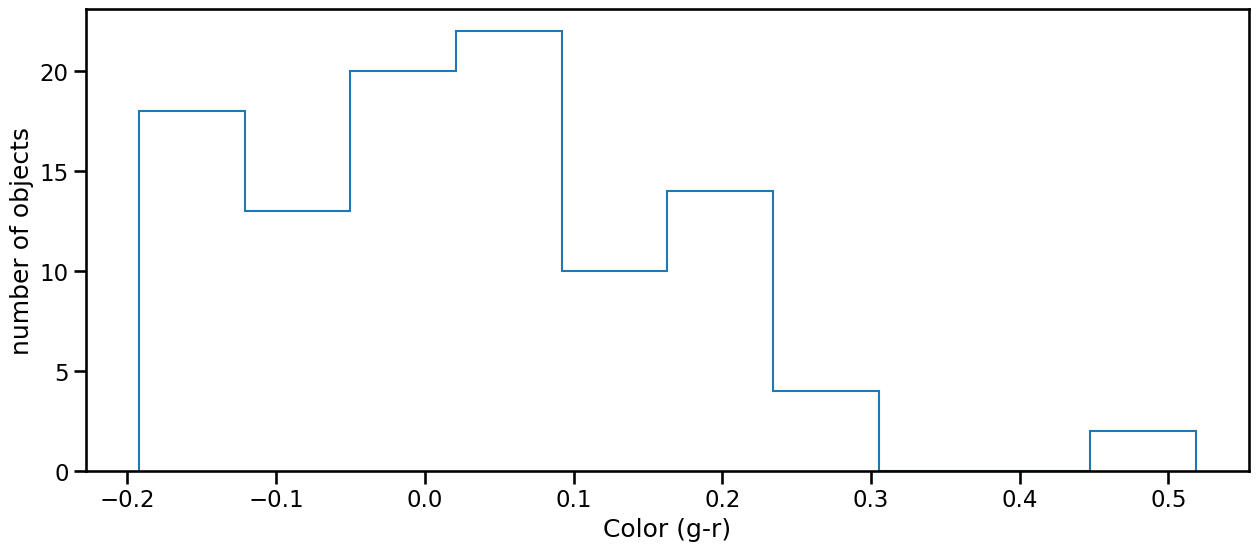

In [10]:
fig = plt.figure(figsize=(15, 6))

plt.hist(candSNe_w_color["v:g-r"], histtype='step')
plt.xlabel("Color (g-r)")
plt.ylabel('number of objects')

### <font color='blue'>Selecting </font>   <font color='orange'>"bluer" color</font>  (e.g. g-r >0)

An example for a possible query: searching alerts which have positive `v:g-r`. Which is equivalent to loosely saying they are "bluer" events.

In [11]:
color_selected = candSNe_w_color[candSNe_w_color["v:g-r"] > 0]

color_selected[['i:objectId', "v:g-r", "v:lastdate"]]

,i:objectId,v:g-r,v:lastdate
7,ZTF21aaqxiaj,0.083787,2021-04-12 05:21:03.001
14,ZTF21aaqvmix,0.170128,2021-04-12 04:37:05.002
16,ZTF21aaqxiaj,0.083787,2021-04-12 04:22:15.004
21,ZTF21aaqvmix,0.170128,2021-04-12 03:46:19.998
22,ZTF21aarcobt,0.217138,2021-04-11 11:16:46.004
23,ZTF21aarcobt,0.217138,2021-04-11 10:50:15.000
29,ZTF21aaqkqwq,0.064339,2021-04-10 10:54:12.004
30,ZTF21aaqkqwq,0.064339,2021-04-10 09:50:37.997
39,ZTF21aaqxiaj,0.092554,2021-04-10 04:48:20.002
41,ZTF21aaqvmix,0.108023,2021-04-10 04:36:47.998


### <font color='blue'>Selecting </font>   <font color='orange'>"bluer" brighter</font>    select alerts with given color and brighter than magpsf 19 (either filter)
An example for a possible query: searching alerts which have negative `v:g-r` and are brighter than a given magnitude.
Please note that this is the latest measured magnitude, not a projection.

In [12]:
bright_candSNe_w_color = color_selected[color_selected["i:magpsf"] < 19]

bright_candSNe_w_color[["i:objectId", "i:magpsf", "v:g-r", "v:rate(g-r)", "v:lastdate"]]

,i:objectId,i:magpsf,v:g-r,v:rate(g-r),v:lastdate
7,ZTF21aaqxiaj,18.376510,0.083787,-0.004334,2021-04-12 05:21:03.001
14,ZTF21aaqvmix,17.434948,0.170128,0.031049,2021-04-12 04:37:05.002
16,ZTF21aaqxiaj,18.292723,0.083787,-0.004334,2021-04-12 04:22:15.004
21,ZTF21aaqvmix,17.264820,0.170128,0.031049,2021-04-12 03:46:19.998
22,ZTF21aarcobt,18.708616,0.217138,0.009848,2021-04-11 11:16:46.004
23,ZTF21aarcobt,18.491478,0.217138,0.009848,2021-04-11 10:50:15.000
39,ZTF21aaqxiaj,18.423260,0.092554,-0.006554,2021-04-10 04:48:20.002
41,ZTF21aaqvmix,17.316248,0.108023,0.000521,2021-04-10 04:36:47.998
42,ZTF21aaqvmix,17.208225,0.108023,0.000521,2021-04-10 04:27:31.997
44,ZTF21aaqxiaj,18.330706,0.092554,-0.006554,2021-04-10 03:54:09.003


If there has been two consecutive nights with color measurement, the `v:rate(g-r)` would be different from `NaN`. This could be an useful added value to inspect the color evolution of the transient and filter candidates.

### <font color='blue'> API query:</font>   <font color='orange'>photometry</font>  for one high-probability alert with given color and brighter than magpsf 19 (either filter)
An example for a possible query: searching alerts with high-classification probability which have positive `v:g-r` and are brighter than a given magnitude.

[SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173) can be trained in different ways. Currently we have models trained to disentangle `SNe Ia vs non Ia` `(snn_snia_vs_nonia)` and `SNe vs other transients` `(snn_sn_vs_all)`. These algorithms have been trained using simulations from [(Muthukrishna et al. 2019)](https://arxiv.org/abs/1904.00014).

In [13]:
prob_threshold = 0.8 # 80% confidence

In [14]:
# select alerts that fit criteria
f1 = bright_candSNe_w_color['d:snn_sn_vs_all'] > prob_threshold
f2 = bright_candSNe_w_color['d:snn_snia_vs_nonia'] > prob_threshold
high_prob_objs = bright_candSNe_w_color[f1 | f2]

In [15]:
# select the latests alert and object
high_prob_obj = high_prob_objs.sort_values(by=['i:ndethist'])['i:objectId'].iloc[-1]

In [16]:
r = requests.post(
  '{}/api/v1/objects'.format(APIURL),
  json={
    'objectId': high_prob_obj,
    'output-format': 'json',
    'withupperlim': 'True',
    'startdate': '2021-03-01', # use a start date
    'stopdate': '2021-03-05', # use a stop date
  }
)

# Format output in a DataFrame
single_object = pd.read_json(io.BytesIO(r.content))

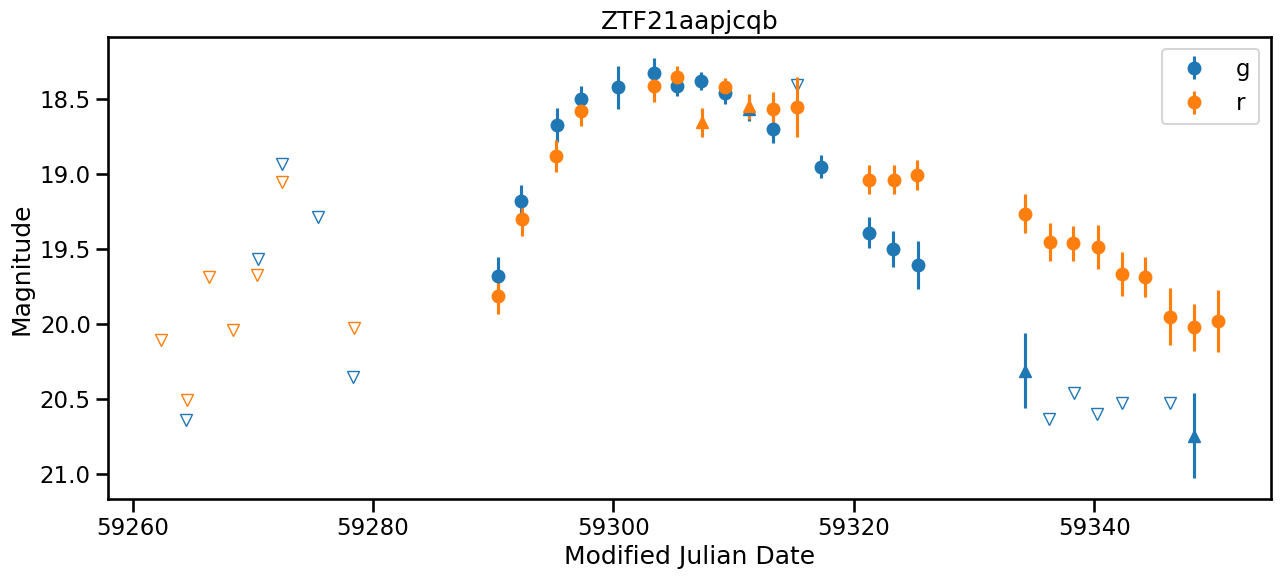


    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    


In [17]:
plot_lc(single_object)

###  <font color='orange'>Color evolution </font>  for one high-probability alert with given color and brighter than magpsf 19 (either filter)

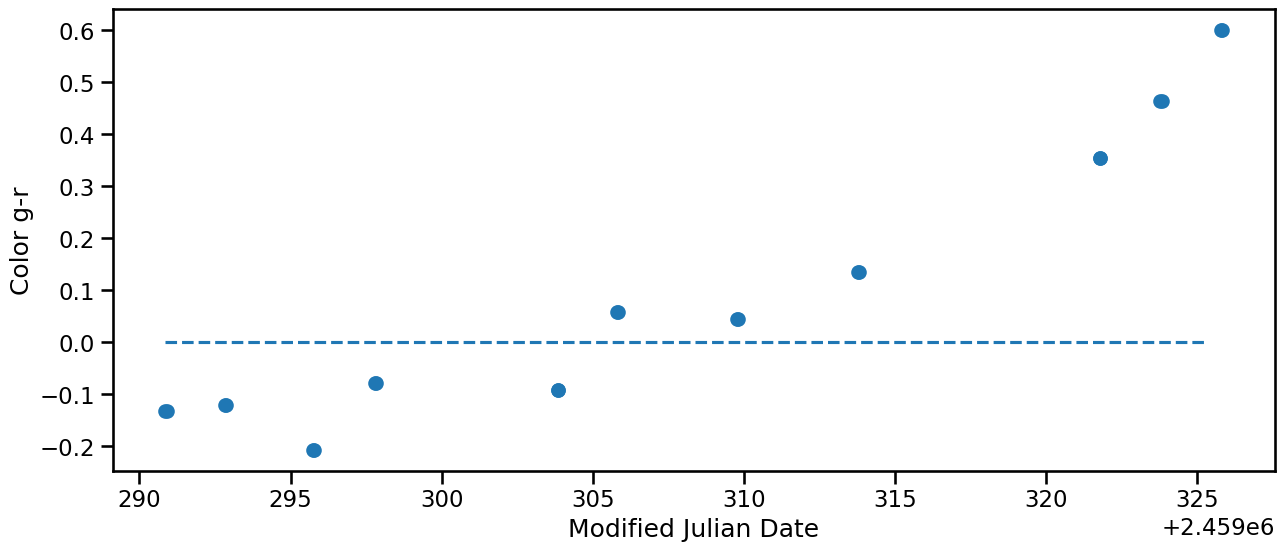

In [18]:
# plot
fig = plt.figure(figsize=(15, 6))
sel = single_object[~single_object['v:g-r'].isna()]
plt.scatter(sel['i:jd'],sel['v:g-r'],label='color')
xarray= np.arange(sel['i:jd'].min(),sel['i:jd'].max(),0.5)
plt.plot(xarray, np.zeros(len(xarray)),linestyle='--')
plt.xlabel('Modified Julian Date')
plt.ylabel('Color g-r')
plt.show()

# 3rd case study: spectroscopically classified type Ia supernovae in Fink

In Fink, we cross-match objects against the [TNS database](https://www.wis-tns.org/). This database provides spectroscopically classified transients with a strong bias for SNe. This is an interesting sample to analyze since many of these SNe have been detected as well by ZTF.

To know all available classes available in TNS see https://api.fink-portal.org/api/v1/classes

### <font color='blue'> API query:</font>   <font color='orange'>latest alerts</font> associated with known type Ia SNe

You can query recent spectroscopically classified SNe in TNS.
For example, query all objects classified as `SN Ia` in TNS between `2020/12/01` and `2021/04/05`, with a maximum of `n alerts` search inside the database

In [19]:
r = requests.post(
  '{}/api/v1/latests'.format(APIURL),
  json={
    'class': '(TNS) SN Ia',        # TNS classification
    'n': '50',                     # n alerts to query in database
    'startdate': '2020-12-01',     # start TNS classification
    'stopdate': '2021-04-05',      # end TNS classification
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

print(pdf[['i:objectId', 'i:ndethist']])

      i:objectId  i:ndethist
0   ZTF18abcoxmc        1074
1   ZTF18abiinnl         531
2   ZTF18abncdhd         548
3   ZTF18abvuceu         715
4   ZTF21aaskyvp           2
5   ZTF18acjxyak          16
6   ZTF21aasctwo           7
7   ZTF21aamwzfi          94
8   ZTF21aaopqqk          40
9   ZTF21aaobcrz          49
10  ZTF21aarskup           4
11  ZTF21aafdxca          80
12  ZTF18aalcxig         717
13  ZTF18abmstte         490
14  ZTF21aaihala          24
15  ZTF21aaqwjlz          24
16  ZTF21aaqztcg          20
17  ZTF21aaplooj          27
18  ZTF21aarjczf          15
19  ZTF18aaibcxu        2340
20  ZTF19aaxqsbn         245
21  ZTF18abltebf          95
22  ZTF18abcscfv         138
23  ZTF21aapvsxv          33
24  ZTF21aakijia          61
25  ZTF18aagrebu         706
26  ZTF21aaplnxw          36
27  ZTF21aaqqlfw          28
28  ZTF18aamlhee        1895
29  ZTF21aanuyro          52
30  ZTF21aaovhxe          97
31  ZTF18acyymoy         168
32  ZTF18aaylbjm          64


### <font color='blue'> API query:</font>   <font color='orange'>photometry</font> of one known type Ia SNe

You can then use the `objects` API service to get all the photometry about a particular object and plot it with limits

In [20]:
selected_SNeIa = 'ZTF21aasctwo'
#pdf['i:objectId'].iloc[2]

In [21]:
r = requests.post(
  '{}/api/v1/objects'.format(APIURL),
  json={
    'objectId': selected_SNeIa,
    'output-format': 'json',
    'withupperlim': 'True'
  }
)

# Format output in a DataFrame
single_object = pd.read_json(io.BytesIO(r.content))

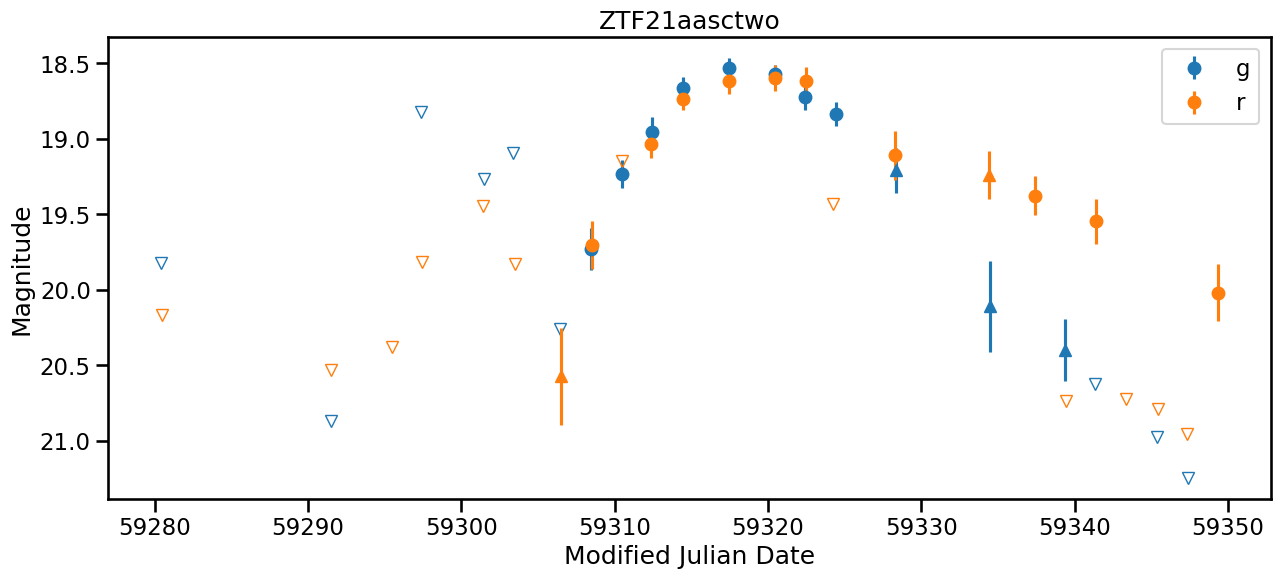


    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    


In [22]:
plot_lc(single_object)

### <font color='blue'> Visualizing:</font> <font color='orange'>Latest ML scores</font> associated with known type Ia SNe

A more general query could be to analyze the ML classification algorithm scores for these recent SNe Ia. To do this we plot the last classification score obtained for the SNe Ia in our list.

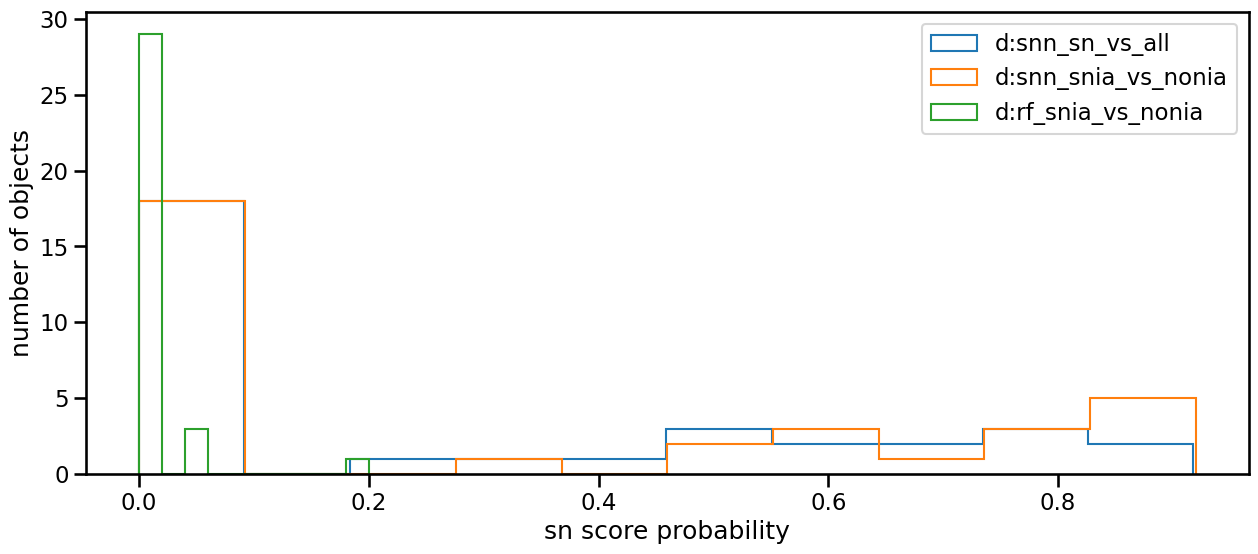

In [23]:
fig = plt.figure(figsize=(15, 6))

for score in ['d:snn_sn_vs_all', 'd:snn_snia_vs_nonia', 'd:rf_snia_vs_nonia']:
    plt.hist(pdf[score], histtype='step', label=score)
plt.xlabel('sn score probability')
plt.ylabel('number of objects')
plt.legend()
plt.show()

Many of these SNe Ia are post-peak since spectroscopic follow-up is usually done around maximum brightness. Note that:
- **'rf_snia_vs_nonia' is designed only for early SNe classification**, therefore it should not provide high scores for post-peak brightness SNe.
- While SuperNNova scores should be valid post-maximum, some of these light-curves may be on the detection tail of the object and/or not have the SN light anymore (e.g. spurious detetions). 

### <font color='blue'> Selecting:</font>   <font color='orange'>SNe with close-by galaxies</font> (not necessarily their host-galaxies)

For your science case, it may be useful to check if there is a close-by galaxy to the spectroscopically classified SNe Ia.

Fink cross-matches each alert to the closest source (within 1'' radius) in the SIMBAD xmatch service providing `d:cdsxmatch` tag.

In [24]:
list_simbad_galaxies = [
    "galaxy",
    "Galaxy",
    "EmG",
    "Seyfert",
    "Seyfert_1",
    "Seyfert_2",
    "BlueCompG",
    "StarburstG",
    "LSB_G",
    "HII_G",
    "High_z_G",
    "GinPair",
    "GinGroup",
    "BClG",
    "GinCl",
    "PartofG",
]

# select alerts that have a cross-matched Galaxy
with_closeby_gal = pdf[pdf['d:cdsxmatch'].isin(list_simbad_galaxies)]

You can expand this query to any type of galaxy present in the SIMBAD catalogue, see http://simbad.u-strasbg.fr/simbad/sim-display?data=otypes  like clusters, Seyfert, etc.

ZTF alert stream also provides useful information of close neighbours:

-`i:distnr`: distance to nearest source in reference image PSF-catalog within 30 arcsec [pixels]

-`i:magnr`: magnitude of nearest source in reference image PSF-catalog within 30 arcsec [mag]

In [25]:
with_closeby_gal[['i:objectId', 'i:distnr', 'i:magnr', 'd:cdsxmatch']]

,i:objectId,i:distnr,i:magnr,d:cdsxmatch
5,ZTF18acjxyak,0.669415,15.710999,Galaxy
17,ZTF21aaplooj,0.928013,16.910000,Galaxy


### <font color='blue'> API query:</font>   <font color='orange'>thumbnails</font> of one known type Ia SNe
It may be useful to visualize in the ZTF provided stamps or thumbnails centered on the transient.

In [26]:
# transfer cutout data
r = requests.post(
  '{}/api/v1/objects'.format(APIURL),
  json={
    'objectId': with_closeby_gal['i:objectId'].iloc[0],
    'withcutouts': 'True'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

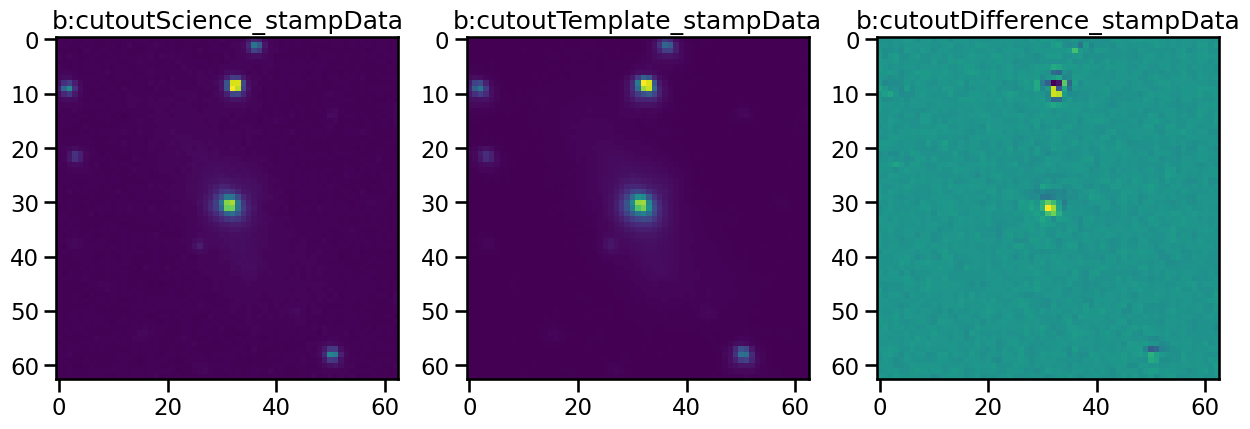

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

columns = [
    'b:cutoutScience_stampData',
    'b:cutoutTemplate_stampData',
    'b:cutoutDifference_stampData'
]
for index, col in enumerate(columns):
    # 2D array
    data = pdf[col].values[0]
    data = np.array(data, dtype=float)
    mask = np.isnan(data)
    data[mask] = 0.0

    # You could optimize the color range to highlight the galaxy
    axes[index].imshow(data)
    axes[index].set_title(col)
plt.show()

Alternatively for displaying images, you can use our cutout service (see `/api/v1/cutouts` on https://api.fink-portal.org for the list of available arguments):

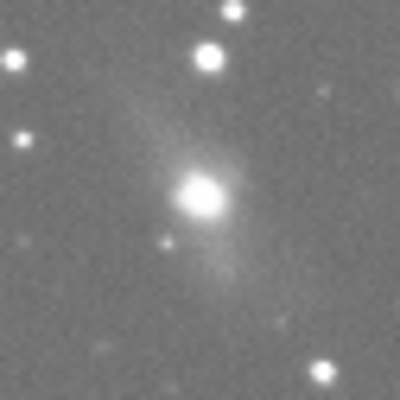

In [28]:
import io
from PIL import Image as im

# get processed image data
r = requests.post(
    '{}/api/v1/cutouts'.format(APIURL),
    json={
        'objectId': with_closeby_gal['i:objectId'].iloc[0],
        'kind': 'Science', # Science, Template, Difference
    }
)

image = im.open(io.BytesIO(r.content))
image.resize((400, 400))

# Summary
In this notebook we have searched for AGNs and SNe:
- Querying Fink's API for latest alerts using known catalogue types, e.g. from SIMBAD or TNS.
- Querying Fink's API for candidate SNe selected using our ML algorithms.
- Filtering all of these alerts according to your science case.
- Querying Fink's API for photometry and thumbnails for a given object.

## An issue to report, or a question to ask: contact@fink-broker.org!